<a href="https://colab.research.google.com/github/Shivp55/DAML/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
# prompt: connnect drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
import kagglehub

# Download the dataset from Kaggle
path = kagglehub.dataset_download("arashnic/microsoft-geolife-gps-trajectory-dataset")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/microsoft-geolife-gps-trajectory-dataset


In [23]:
# Path to the dataset (replace with the actual path)
data_dir = path  # the path where the dataset was downloaded


In [15]:
import os
import pandas as pd

# Path to the dataset (replace with the actual path)
data_dir = path  # the path where the dataset was downloaded

def load_all_trajectories(data_dir):
    """
    Loads all trajectories from all users in the dataset.

    Args:
        data_dir (str): The path to the root directory of the dataset.

    Returns:
        pandas.DataFrame: A DataFrame containing all the trajectory data.
    """
    all_data = []

    # Iterate through the numbered subfolders within the 'Data' folder
    # Corrected path to 'Geolife Trajectories 1.3/Data'
    data_folder = os.path.join(data_dir, "Geolife Trajectories 1.3", "Data")
    for user_dir in os.listdir(data_folder):
        # Construct the path to the 'Trajectory' folder for each user
        # Corrected path construction to user's 'Trajectory' folder
        user_trajectory_path = os.path.join(data_folder, user_dir, "Trajectory")

        # Check if the 'Trajectory' folder exists before trying to access it
        if os.path.exists(user_trajectory_path):
            # Load the data for the current user using the previously defined function
            user_data = load_trajectory(user_trajectory_path)
            all_data.append(user_data)

    # Concatenate all the data into a single DataFrame
    return pd.concat(all_data, ignore_index=True)

def load_trajectory(user_trajectory_path):
    """
    Loads trajectory data from a specific user's 'Trajectory' folder.

    Args:
        user_trajectory_path (str): The path to the user's 'Trajectory' folder.

    Returns:
        pandas.DataFrame: A DataFrame containing the user's trajectory data.
    """
    trajectory_files = os.listdir(user_trajectory_path)
    data = []

    for file in trajectory_files:
        if file.endswith(".plt"):
            file_path = os.path.join(user_trajectory_path, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()

            trajectory = []
            for line in lines[6:]:
                parts = line.split(',')
                try:  # Added try-except block for potential errors in data
                    latitude = float(parts[0].strip())
                    longitude = float(parts[1].strip())
                    trajectory.append([latitude, longitude])
                except ValueError:
                    print(f"Skipping line with invalid data: {line}")

            trajectory_df = pd.DataFrame(trajectory, columns=['Latitude', 'Longitude'])
            data.append(trajectory_df)

    return pd.concat(data, ignore_index=True)


# Load all trajectories from all users
all_trajectory_data = load_all_trajectories(data_dir)
print(all_trajectory_data.head())

    Latitude   Longitude
0  39.979722  116.307926
1  39.979829  116.308067
2  39.979721  116.308002
3  39.979744  116.307918
4  39.979841  116.307903


In [16]:
# prompt: print total number of entries in all_trajectory_data

print(len(all_trajectory_data))


24876978


In [38]:
import os
import pandas as pd
import numpy as np



# Path to the dataset
data_dir = path  # Or your local path

def load_all_trajectories(data_dir, max_users=10, max_files_per_user=100): # Added limits for testing
    """Loads trajectories with limits on users and files per user."""
    all_data = []
    user_count = 0
    data_folder = os.path.join(data_dir, "Geolife Trajectories 1.3", "Data")
    for user_dir in os.listdir(data_folder):
        if user_count >= max_users:  # Limit the number of users processed
            break
        user_trajectory_path = os.path.join(data_folder, user_dir, "Trajectory")
        if os.path.exists(user_trajectory_path):
            user_data = load_trajectory(user_trajectory_path, max_files=max_files_per_user)
            all_data.append(user_data)
            user_count += 1
    return pd.concat(all_data, ignore_index=True)


def load_trajectory(user_trajectory_path, max_files=200): # Added a limit to the number of files
    """Loads trajectory data with a limit on the number of files."""
    trajectory_files = os.listdir(user_trajectory_path)
    data = []
    file_count = 0
    for file in trajectory_files:
      if file_count >= max_files:
        break
      if file.endswith(".plt"):
          file_path = os.path.join(user_trajectory_path, file)
          with open(file_path, 'r') as f:
              lines = f.readlines()

          trajectory = []
          for line in lines[6:]:
              parts = line.split(',')
              try:  # Added try-except block for potential errors in data
                  latitude = float(parts[0].strip())
                  longitude = float(parts[1].strip())
                  trajectory.append([latitude, longitude])
              except ValueError:
                  print(f"Skipping line with invalid data: {line}")

          trajectory_df = pd.DataFrame(trajectory, columns=['Latitude', 'Longitude'])
          data.append(trajectory_df)

          file_count +=1 # Increment file count after processing a file
    return pd.concat(data, ignore_index=True)

# Load a reduced set of trajectories
all_trajectory_data = load_all_trajectories(data_dir)
print(all_trajectory_data.head())
print(len(all_trajectory_data))

    Latitude   Longitude
0  39.965813  116.396532
1  39.965871  116.396451
2  39.965834  116.396549
3  39.965919  116.396449
4  39.965906  116.396482
149442


In [28]:
# prompt: find the max number of users and total files in each of the users

import os
import pandas as pd

# Path to the dataset (replace with the actual path)
# data_dir = "/content/drive/MyDrive/Geolife Trajectories 1.3" #Example path, replace with your actual path

def count_files_per_user(data_dir):
    user_file_counts = {}
    data_folder = os.path.join(data_dir, "Geolife Trajectories 1.3", "Data")
    for user_dir in os.listdir(data_folder):
        user_trajectory_path = os.path.join(data_folder, user_dir, "Trajectory")
        if os.path.exists(user_trajectory_path):
            file_count = 0
            for file in os.listdir(user_trajectory_path):
                if file.endswith(".plt"):
                    file_count += 1
            user_file_counts[user_dir] = file_count
    return user_file_counts

file_counts = count_files_per_user(data_dir)

max_user = max(file_counts, key=file_counts.get)
max_files = file_counts[max_user]

print(f"User with the most files: {max_user}, File count: {max_files}")

total_files = sum(file_counts.values())
print(f"Total number of .plt files across all users: {total_files}")

#Alternative using pandas for better visualization
user_data = []
data_folder = os.path.join(data_dir, "Geolife Trajectories 1.3", "Data")
for user_dir in os.listdir(data_folder):
  user_trajectory_path = os.path.join(data_folder, user_dir, "Trajectory")
  if os.path.exists(user_trajectory_path):
      file_count = 0
      for file in os.listdir(user_trajectory_path):
        if file.endswith(".plt"):
          file_count += 1
      user_data.append([user_dir, file_count])

df = pd.DataFrame(user_data, columns=['user', 'file_count'])
print(df)
print(f"Total users:{len(df)}")
print(f"Total files: {df['file_count'].sum()}")
print(f"Max files per user: {df['file_count'].max()}")


User with the most files: 128, File count: 2153
Total number of .plt files across all users: 18670
    user  file_count
0    135          13
1    057          22
2    086           6
3    121           5
4    061          20
..   ...         ...
177  032          16
178  030         296
179  172          21
180  136          17
181  085         427

[182 rows x 2 columns]
Total users:182
Total files: 18670
Max files per user: 2153


In [30]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize the latitude and longitude
scaler = MinMaxScaler(feature_range=(0, 1))
all_trajectory_data[['Latitude', 'Longitude']] = scaler.fit_transform(all_trajectory_data[['Latitude', 'Longitude']])

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])  # Prediction for the next point
    return np.array(sequences), np.array(labels)


In [31]:
from sklearn.model_selection import train_test_split

# Prepare sequences and labels
sequence_length = 50
sequences, labels = create_sequences(all_trajectory_data[['Latitude', 'Longitude']].values, sequence_length)

# Split the data into training and testing
X_train, X_temp, y_train, y_temp = train_test_split(sequences, labels, test_size=0.3, random_state=42)

# Split the temp data into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now, we have X_train, X_val, X_test, y_train, y_val, y_test
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (104574, 50, 2)
Validation data shape: (22409, 50, 2)
Testing data shape: (22409, 50, 2)


In [32]:
# Split the data into train, validation, and test sets
def split_data(sequences, labels):
    X_train, X_temp, y_train, y_temp = train_test_split(sequences, labels, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Define the LSTM model
class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=64, output_size=2):
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])
        return predictions

In [33]:
# Train the model
def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=64):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        train_inputs = torch.Tensor(X_train)
        train_labels = torch.Tensor(y_train)

        # Forward pass
        train_output = model(train_inputs)
        train_loss = criterion(train_output, train_labels)

        # Backward pass
        train_loss.backward()
        optimizer.step()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_inputs = torch.Tensor(X_val)
            val_labels = torch.Tensor(y_val)
            val_output = model(val_inputs)
            val_loss = criterion(val_output, val_labels)


        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

# Evaluate the model on the test set
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_inputs = torch.Tensor(X_test)
        test_labels = torch.Tensor(y_test)
        test_predictions = model(test_inputs)
        mse = mean_squared_error(test_labels.numpy(), test_predictions.numpy())
        print(f"Test MSE: {mse}")


In [34]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
all_trajectory_data[['Latitude', 'Longitude']] = scaler.fit_transform(all_trajectory_data[['Latitude', 'Longitude']])

# Create sequences
sequence_length = 50
sequences, labels = create_sequences(all_trajectory_data[['Latitude', 'Longitude']].values, sequence_length)

In [35]:

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(sequences, labels)

In [36]:
# prompt: print the total data available for train val and test

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Total training data: {X_train.shape[0]}")
print(f"Total validation data: {X_val.shape[0]}")
print(f"Total testing data: {X_test.shape[0]}")


Training data shape: (104574, 50, 2)
Validation data shape: (22409, 50, 2)
Testing data shape: (22409, 50, 2)
Total training data: 104574
Total validation data: 22409
Total testing data: 22409


In [ ]:
# Initialize the model
model = TrajectoryLSTM(input_size=2, hidden_layer_size=64, output_size=2)

# Train the model
train_model(model, X_train, y_train, X_val, y_val, epochs=20)

Epoch 1/20, Training Loss: 0.19786252081394196, Validation Loss: 0.1856103390455246
Epoch 2/20, Training Loss: 0.18798333406448364, Validation Loss: 0.1760070025920868
Epoch 3/20, Training Loss: 0.17824505269527435, Validation Loss: 0.1665135771036148
Epoch 4/20, Training Loss: 0.1686142385005951, Validation Loss: 0.15710285305976868
Epoch 5/20, Training Loss: 0.1590629369020462, Validation Loss: 0.14775218069553375
Epoch 6/20, Training Loss: 0.14956754446029663, Validation Loss: 0.1384437531232834
Epoch 7/20, Training Loss: 0.1401093304157257, Validation Loss: 0.12916524708271027
Epoch 8/20, Training Loss: 0.13067488372325897, Validation Loss: 0.11991144716739655
Epoch 9/20, Training Loss: 0.12125778198242188, Validation Loss: 0.11068941652774811
Epoch 10/20, Training Loss: 0.11186359077692032, Validation Loss: 0.10152696818113327
Epoch 11/20, Training Loss: 0.10251849889755249, Validation Loss: 0.09248705953359604
Epoch 12/20, Training Loss: 0.09328359365463257, Validation Loss: 0.08

In [ ]:
# Save the trained model
# Create the directory if it doesn't exist
save_dir = "/content/drive/MyDrive/RNN"  # Replace with your desired path
os.makedirs(save_dir, exist_ok=True)

model_save_path = os.path.join(save_dir, "trajectory_model_baseline.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/RNN/trajectory_model_baseline.pth


<ipython-input-16-ee612abd7770>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


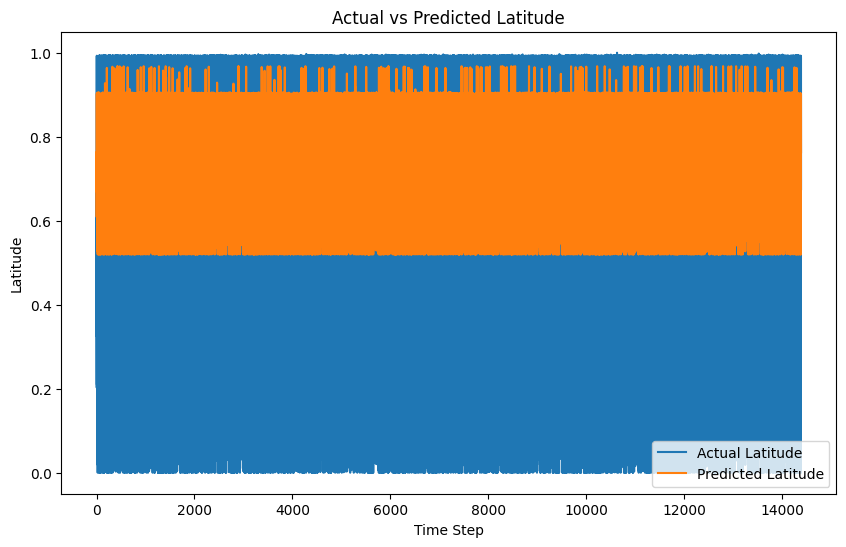

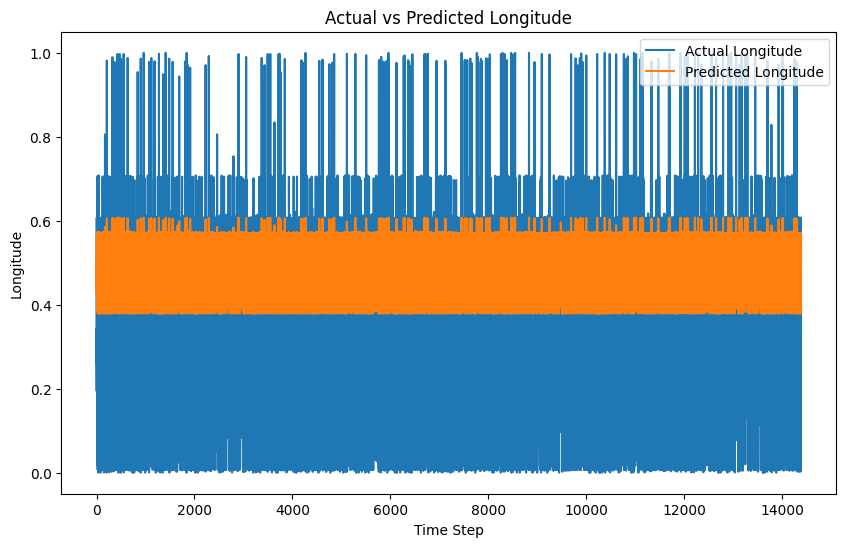

In [ ]:
# prompt: plot graphs from the above model trained

import matplotlib.pyplot as plt

# Load the saved model
model = TrajectoryLSTM(input_size=2, hidden_layer_size=64, output_size=2)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Make predictions on the test set
with torch.no_grad():
    test_inputs = torch.Tensor(X_test)
    test_predictions = model(test_inputs)

# Inverse transform the predictions and actual values
test_predictions = scaler.inverse_transform(test_predictions.numpy())
y_test = scaler.inverse_transform(y_test)

# Plot the predictions vs actual values for latitude
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='Actual Latitude')
plt.plot(test_predictions[:, 0], label='Predicted Latitude')
plt.xlabel('Time Step')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Latitude')
plt.legend()
plt.show()

# Plot the predictions vs actual values for longitude
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 1], label='Actual Longitude')
plt.plot(test_predictions[:, 1], label='Predicted Longitude')
plt.xlabel('Time Step')
plt.ylabel('Longitude')
plt.title('Actual vs Predicted Longitude')
plt.legend()
plt.show()


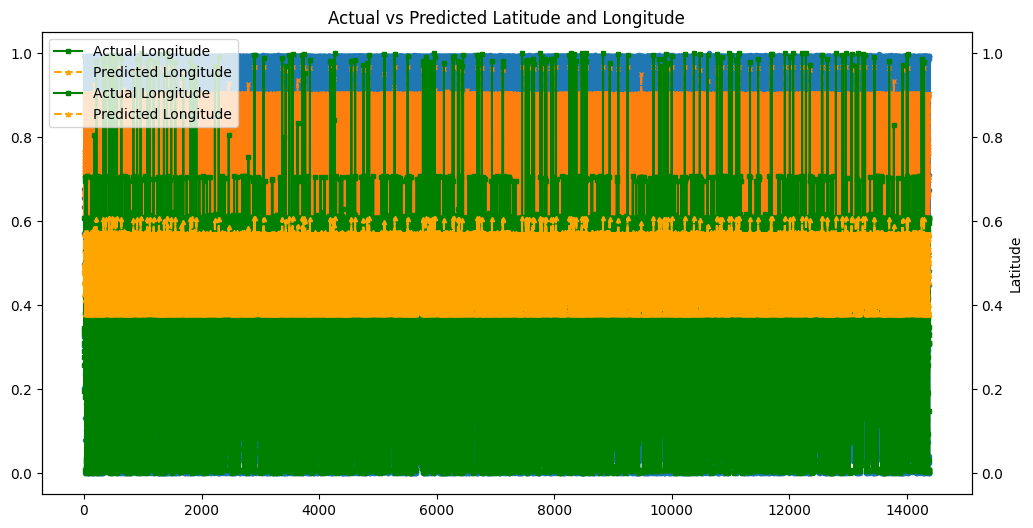

In [ ]:
# prompt: plot some line graphs as well

import matplotlib.pyplot as plt
# ... (Your existing code)

# ... (After making predictions and inverse transforming)

# Plot the predictions vs actual values for latitude and longitude on the same plot
plt.figure(figsize=(12, 6))

# Latitude
plt.plot(y_test[:, 0], label='Actual Latitude', linestyle='-', marker='o', markersize=3)
plt.plot(test_predictions[:, 0], label='Predicted Latitude', linestyle='--', marker='x', markersize=3)


# Longitude (on a secondary y-axis)
plt.gca().twinx()
plt.plot(y_test[:, 1], label='Actual Longitude', linestyle='-', marker='s', markersize=3, color='green')
plt.plot(test_predictions[:, 1], label='Predicted Longitude', linestyle='--', marker='^', markersize=3, color='orange')


plt.xlabel('Time Step')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Latitude and Longitude')

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


MSE Latitude: 0.08559911977464896
MSE Longitude: 0.03614502760511021


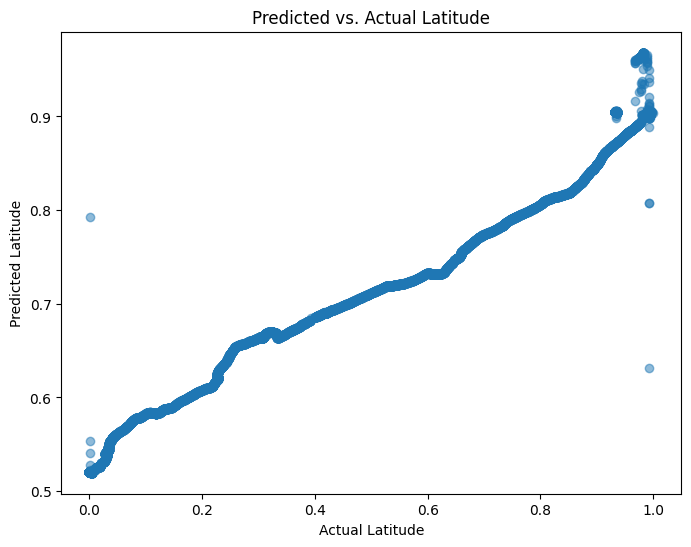

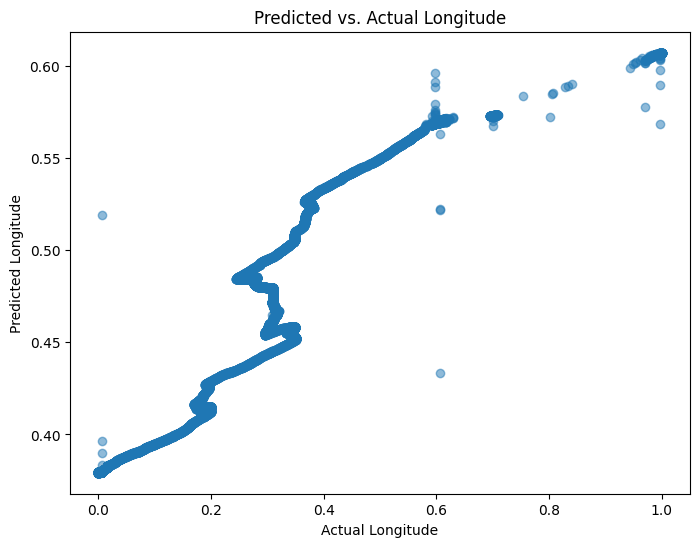

In [ ]:
# prompt: any other types of graphs or heatmaps or confusion matrix that i can plot?

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ... (Your existing code)

# ... (After making predictions and inverse transforming)


# Calculate the Mean Squared Error (MSE) for latitude and longitude separately
mse_lat = mean_squared_error(y_test[:, 0], test_predictions[:, 0])
mse_lon = mean_squared_error(y_test[:, 1], test_predictions[:, 1])

print(f"MSE Latitude: {mse_lat}")
print(f"MSE Longitude: {mse_lon}")


# Example 1:  Scatter Plot of Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], test_predictions[:, 0], alpha=0.5)  # Latitude
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')
plt.title('Predicted vs. Actual Latitude')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 1], test_predictions[:, 1], alpha=0.5) #Longitude
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')
plt.title('Predicted vs. Actual Longitude')
plt.show()


<ipython-input-19-f01001e804ad>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test[:, 0], label='Actual Latitude', shade=True)
<ipython-input-19-f01001e804ad>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_predictions[:, 0], label='Predicted Latitude', shade=True)


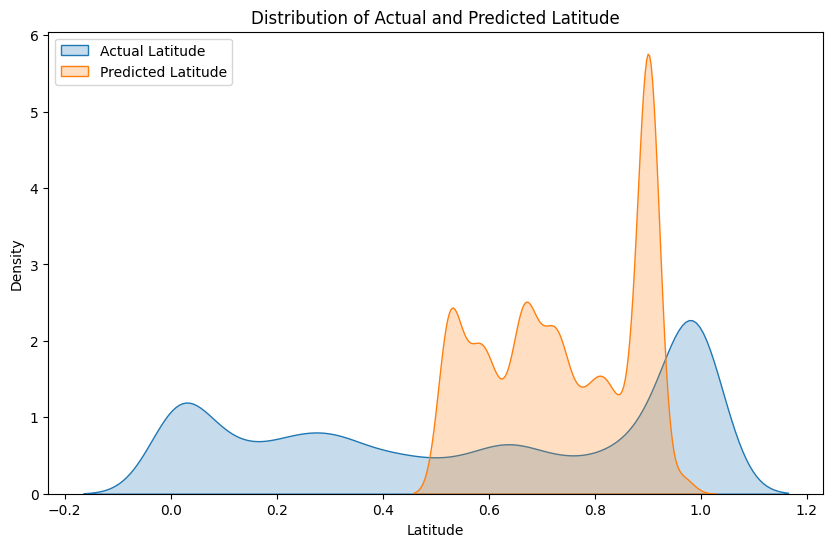

In [ ]:

# Example 2:  Distribution Plots
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test[:, 0], label='Actual Latitude', shade=True)
sns.kdeplot(test_predictions[:, 0], label='Predicted Latitude', shade=True)
plt.xlabel('Latitude')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Latitude')
plt.legend()
plt.show()



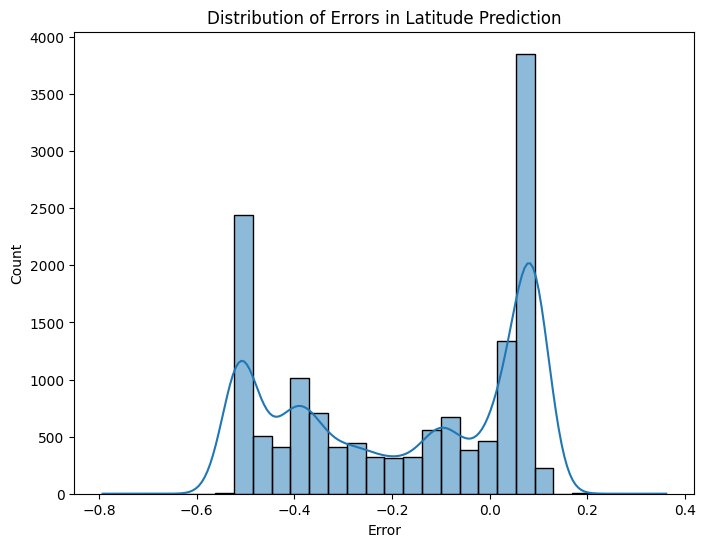

In [ ]:
# Example 3:  Error Distribution
errors_lat = y_test[:, 0] - test_predictions[:, 0]
plt.figure(figsize=(8,6))
sns.histplot(errors_lat, kde=True)
plt.title('Distribution of Errors in Latitude Prediction')
plt.xlabel('Error')
plt.show()

In [ ]:
# prompt: measure accuracy on test data

# Evaluate the model on the test set
evaluate_model(model, X_test, y_test)


Test MSE: 0.06087149679660797


In [ ]:
# prompt: how can i do prediction to check whether model is performing good or bad

import numpy as np
# ... (Your existing code)

# Evaluate the model on the test set
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_inputs = torch.Tensor(X_test)
        test_labels = torch.Tensor(y_test)
        test_predictions = model(test_inputs)
        mse = mean_squared_error(test_labels.numpy(), test_predictions.numpy())
        rmse = np.sqrt(mse)  # Calculate RMSE
        print(f"Test MSE: {mse}")
        print(f"Test RMSE: {rmse}") #Print RMSE
        return mse, rmse #return mse and rmse

# ... (rest of your code)

# Evaluate and get MSE and RMSE
mse, rmse = evaluate_model(model, X_test, y_test)

#Example of using a threshold for RMSE
rmse_threshold = 0.01 # Example threshold value, needs to be adjusted based on requirements
if rmse < rmse_threshold:
  print("Model is performing well based on the defined RMSE threshold")
else:
  print("Model performance is below the defined RMSE threshold.")


Test MSE: 0.06087149679660797
Test RMSE: 0.24672149642179128
Model performance is below the defined RMSE threshold.


In [ ]:
# Evaluate the model on the test set
evaluate_model(model, X_test, y_test)

Test MSE: 0.06087149679660797


In [39]:
# prompt: make changes in archtecture and make it a little more complex model

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import kagglehub

# ... (Existing code for data loading and preprocessing)


# Define a more complex LSTM model with additional layers and dropout
class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=128, num_layers=2, output_size=2, dropout=0.2):
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_layer_size, 64)  # Added a hidden layer
        self.relu = nn.ReLU()  # Added ReLU activation
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc1(lstm_out[:, -1, :])
        out = self.relu(out)  # Apply ReLU
        predictions = self.fc2(out)
        return predictions

# ... (Existing code for data splitting and normalization)

# Initialize the more complex model
model = TrajectoryLSTM(input_size=2, hidden_layer_size=128, num_layers=2, output_size=2, dropout=0.2)

In [40]:
# Train the model
train_model(model, X_train, y_train, X_val, y_val, epochs=20)

Epoch 1/20, Training Loss: 0.40414637327194214, Validation Loss: 0.38417351245880127
Epoch 2/20, Training Loss: 0.3813302218914032, Validation Loss: 0.3651038706302643
Epoch 3/20, Training Loss: 0.36239415407180786, Validation Loss: 0.3483395278453827
Epoch 4/20, Training Loss: 0.345716267824173, Validation Loss: 0.32987406849861145
Epoch 5/20, Training Loss: 0.3274309039115906, Validation Loss: 0.31232038140296936
Epoch 6/20, Training Loss: 0.30994313955307007, Validation Loss: 0.2916283905506134
Epoch 7/20, Training Loss: 0.2893982231616974, Validation Loss: 0.2658821642398834
Epoch 8/20, Training Loss: 0.26388707756996155, Validation Loss: 0.2314714789390564
Epoch 9/20, Training Loss: 0.2296438068151474, Validation Loss: 0.18082508444786072
Epoch 10/20, Training Loss: 0.17969632148742676, Validation Loss: 0.1141354963183403
Epoch 11/20, Training Loss: 0.1138080358505249, Validation Loss: 0.05438957363367081
Epoch 12/20, Training Loss: 0.05488794296979904, Validation Loss: 0.08308382

In [41]:
# Create the directory if it doesn't exist
save_dir = "/content/drive/MyDrive/RNN"  # Replace with your desired path
os.makedirs(save_dir, exist_ok=True)

model_save_path = os.path.join(save_dir, "trajectory_model_variation_1.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")


# Load the saved model
model = TrajectoryLSTM(input_size=2, hidden_layer_size=128, num_layers=2, output_size=2, dropout=0.2)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Evaluation on the test set
evaluate_model(model, X_test, y_test)


Model saved to: /content/drive/MyDrive/RNN/trajectory_model_variation_1.pth
Test MSE: 0.0678258165717125


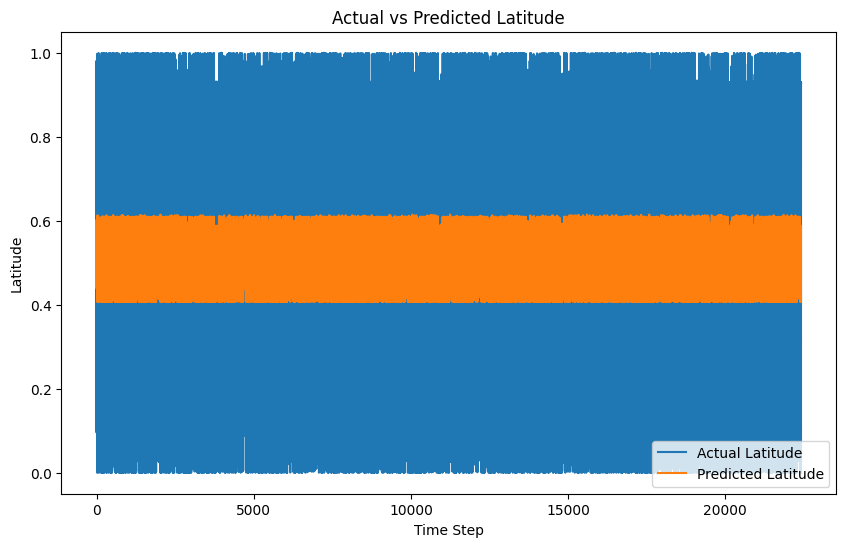

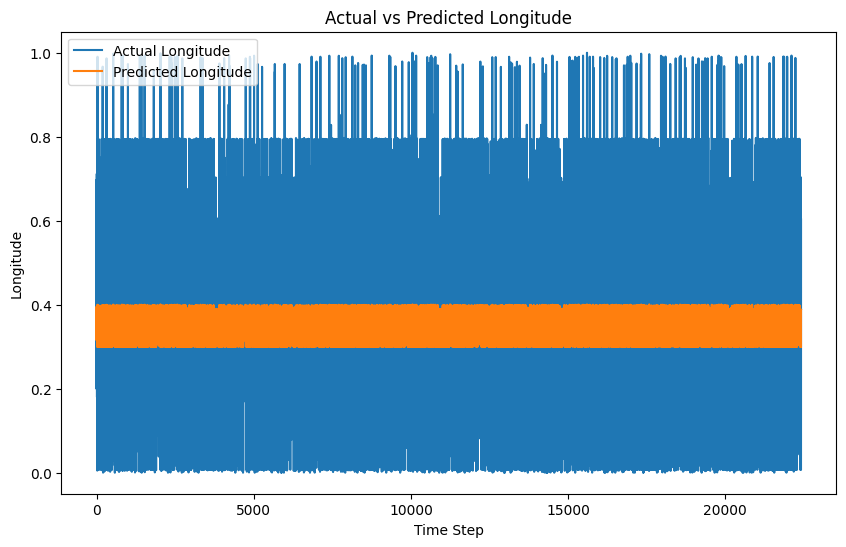

In [43]:
import matplotlib.pyplot as plt
# Make predictions on the test set
with torch.no_grad():
    test_inputs = torch.Tensor(X_test)
    test_predictions = model(test_inputs)

# Inverse transform the predictions and actual values
test_predictions = scaler.inverse_transform(test_predictions.numpy())
y_test = scaler.inverse_transform(y_test)

# Plot the predictions vs actual values for latitude
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='Actual Latitude')
plt.plot(test_predictions[:, 0], label='Predicted Latitude')
plt.xlabel('Time Step')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Latitude')
plt.legend()
plt.show()

# Plot the predictions vs actual values for longitude
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 1], label='Actual Longitude')
plt.plot(test_predictions[:, 1], label='Predicted Longitude')
plt.xlabel('Time Step')
plt.ylabel('Longitude')
plt.title('Actual vs Predicted Longitude')
plt.legend()
plt.show()


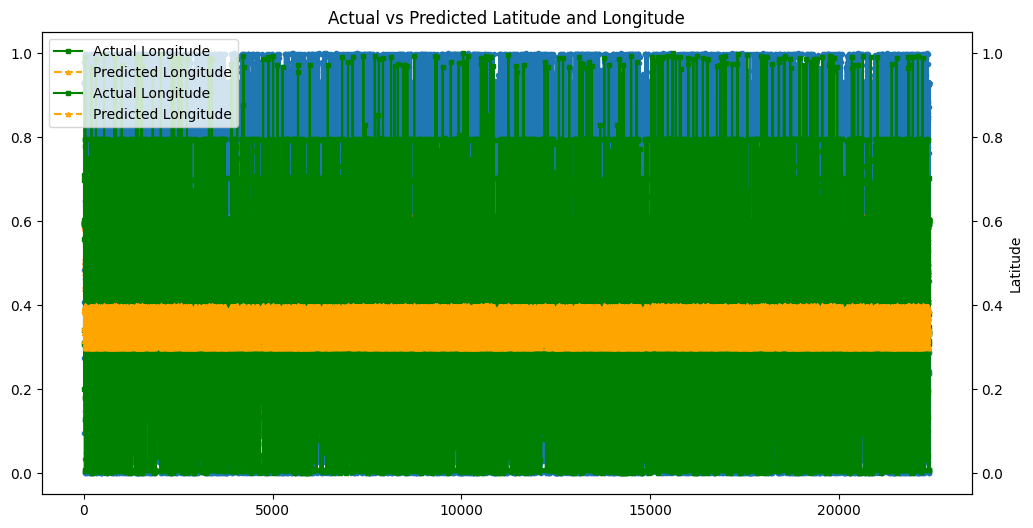

In [44]:
# prompt: plot some line graphs as well

import matplotlib.pyplot as plt
# ... (Your existing code)

# ... (After making predictions and inverse transforming)

# Plot the predictions vs actual values for latitude and longitude on the same plot
plt.figure(figsize=(12, 6))

# Latitude
plt.plot(y_test[:, 0], label='Actual Latitude', linestyle='-', marker='o', markersize=3)
plt.plot(test_predictions[:, 0], label='Predicted Latitude', linestyle='--', marker='x', markersize=3)


# Longitude (on a secondary y-axis)
plt.gca().twinx()
plt.plot(y_test[:, 1], label='Actual Longitude', linestyle='-', marker='s', markersize=3, color='green')
plt.plot(test_predictions[:, 1], label='Predicted Longitude', linestyle='--', marker='^', markersize=3, color='orange')


plt.xlabel('Time Step')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Latitude and Longitude')

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


MSE Latitude: 0.09551938700292241
MSE Longitude: 0.04013266809671232


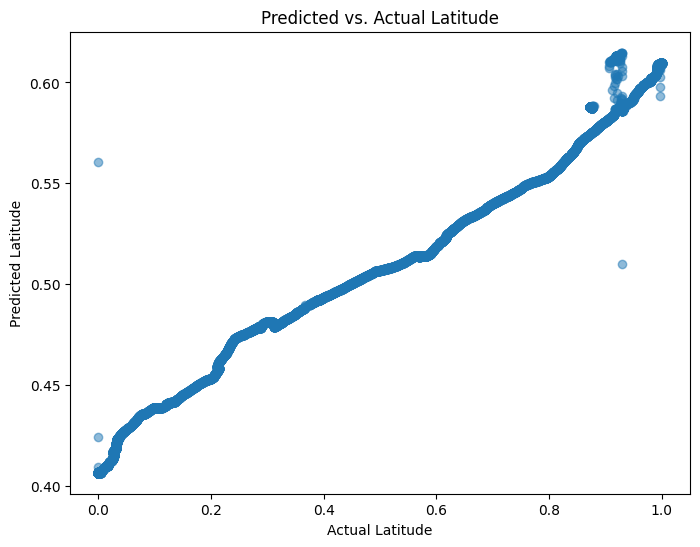

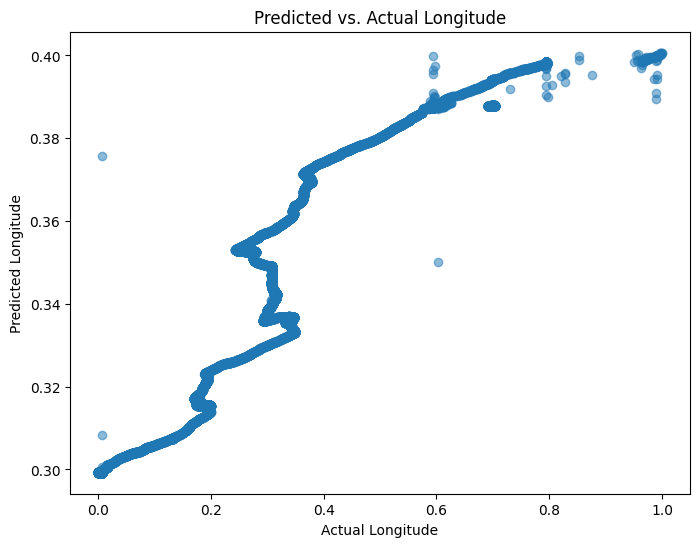

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the Mean Squared Error (MSE) for latitude and longitude separately
mse_lat = mean_squared_error(y_test[:, 0], test_predictions[:, 0])
mse_lon = mean_squared_error(y_test[:, 1], test_predictions[:, 1])

print(f"MSE Latitude: {mse_lat}")
print(f"MSE Longitude: {mse_lon}")


# Example 1:  Scatter Plot of Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], test_predictions[:, 0], alpha=0.5)  # Latitude
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')
plt.title('Predicted vs. Actual Latitude')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 1], test_predictions[:, 1], alpha=0.5) #Longitude
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')
plt.title('Predicted vs. Actual Longitude')
plt.show()


<ipython-input-46-f01001e804ad>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test[:, 0], label='Actual Latitude', shade=True)
<ipython-input-46-f01001e804ad>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_predictions[:, 0], label='Predicted Latitude', shade=True)


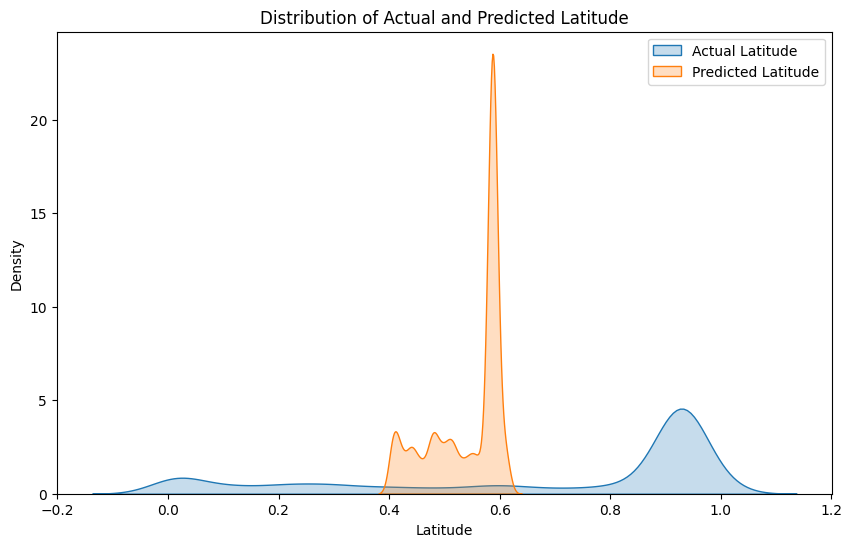

In [46]:

# Example 2:  Distribution Plots
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test[:, 0], label='Actual Latitude', shade=True)
sns.kdeplot(test_predictions[:, 0], label='Predicted Latitude', shade=True)
plt.xlabel('Latitude')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Latitude')
plt.legend()
plt.show()



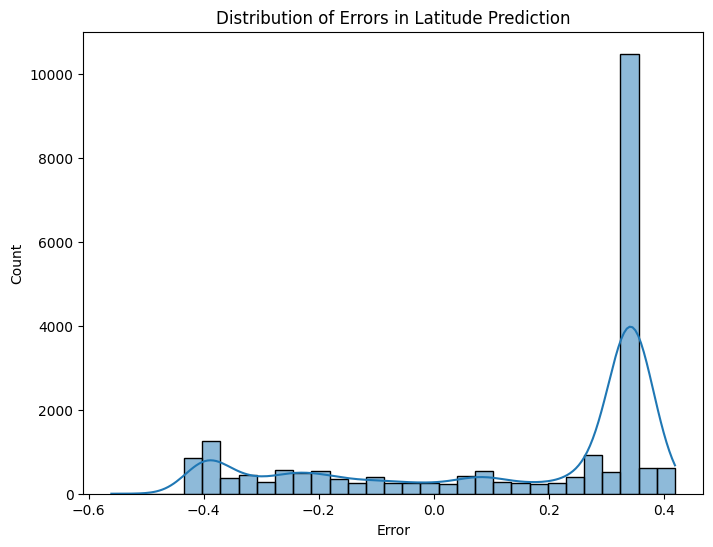

In [47]:
# Example 3:  Error Distribution
errors_lat = y_test[:, 0] - test_predictions[:, 0]
plt.figure(figsize=(8,6))
sns.histplot(errors_lat, kde=True)
plt.title('Distribution of Errors in Latitude Prediction')
plt.xlabel('Error')
plt.show()

In [ ]:
# Define an even more complex LSTM model with attention mechanism
class TrajectoryLSTMAttention(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=128, num_layers=2, output_size=2, dropout=0.2):
        super(TrajectoryLSTMAttention, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_layer_size, 1)  # Attention mechanism
        self.fc1 = nn.Linear(hidden_layer_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        out = self.fc1(context_vector)
        out = self.relu(out)
        predictions = self.fc2(out)
        return predictions

# ... (Existing code for data splitting and normalization)

# Initialize the model with attention
model = TrajectoryLSTMAttention(input_size=2, hidden_layer_size=128, num_layers=2, output_size=2, dropout=0.2)

# ... (Existing code for training and evaluation functions)

# Train the model
train_model(model, X_train, y_train, X_val, y_val, epochs=30) # Increased epochs for potential improvement

# Save the trained model with attention
save_dir = "/content/drive/MyDrive/RNN"
os.makedirs(save_dir, exist_ok=True)
model_save_path = os.path.join(save_dir, "trajectory_model_variation_2.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

# Load the saved model
model = TrajectoryLSTMAttention(input_size=2, hidden_layer_size=128, num_layers=2, output_size=2, dropout=0.2)
model.load_state_dict(torch.load(model_save_path))
model.eval()


# Evaluate the model on the test set
evaluate_model(model, X_test, y_test)

Epoch 1/30, Training Loss: 0.3851953148841858, Validation Loss: 0.3635996878147125
Epoch 2/30, Training Loss: 0.36085930466651917, Validation Loss: 0.3413788080215454
Epoch 3/30, Training Loss: 0.3387758433818817, Validation Loss: 0.32064586877822876
Epoch 4/30, Training Loss: 0.318184494972229, Validation Loss: 0.2979518473148346
Epoch 5/30, Training Loss: 0.2956535518169403, Validation Loss: 0.2717427909374237
Epoch 6/30, Training Loss: 0.26964637637138367, Validation Loss: 0.2415194809436798
Epoch 7/30, Training Loss: 0.23965884745121002, Validation Loss: 0.20461100339889526
Epoch 8/30, Training Loss: 0.20310872793197632, Validation Loss: 0.1577633023262024
Epoch 9/30, Training Loss: 0.1567583829164505, Validation Loss: 0.1018960028886795
Epoch 10/30, Training Loss: 0.10165038704872131, Validation Loss: 0.062022238969802856
Epoch 11/30, Training Loss: 0.06260602176189423, Validation Loss: 0.10721966624259949
Epoch 12/30, Training Loss: 0.108195960521698, Validation Loss: 0.109122782

In [ ]:
# Make predictions on the test set
with torch.no_grad():
    test_inputs = torch.Tensor(X_test)
    test_predictions = model(test_inputs)

# Inverse transform the predictions and actual values
test_predictions = scaler.inverse_transform(test_predictions.numpy())
y_test = scaler.inverse_transform(y_test)

# Plot the predictions vs actual values for latitude
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='Actual Latitude')
plt.plot(test_predictions[:, 0], label='Predicted Latitude')
plt.xlabel('Time Step')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Latitude')
plt.legend()
plt.show()

# Plot the predictions vs actual values for longitude
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 1], label='Actual Longitude')
plt.plot(test_predictions[:, 1], label='Predicted Longitude')
plt.xlabel('Time Step')
plt.ylabel('Longitude')
plt.title('Actual vs Predicted Longitude')
plt.legend()
plt.show()


In [ ]:
# prompt: plot some line graphs as well

import matplotlib.pyplot as plt
# ... (Your existing code)

# ... (After making predictions and inverse transforming)

# Plot the predictions vs actual values for latitude and longitude on the same plot
plt.figure(figsize=(12, 6))

# Latitude
plt.plot(y_test[:, 0], label='Actual Latitude', linestyle='-', marker='o', markersize=3)
plt.plot(test_predictions[:, 0], label='Predicted Latitude', linestyle='--', marker='x', markersize=3)


# Longitude (on a secondary y-axis)
plt.gca().twinx()
plt.plot(y_test[:, 1], label='Actual Longitude', linestyle='-', marker='s', markersize=3, color='green')
plt.plot(test_predictions[:, 1], label='Predicted Longitude', linestyle='--', marker='^', markersize=3, color='orange')


plt.xlabel('Time Step')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Latitude and Longitude')

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the Mean Squared Error (MSE) for latitude and longitude separately
mse_lat = mean_squared_error(y_test[:, 0], test_predictions[:, 0])
mse_lon = mean_squared_error(y_test[:, 1], test_predictions[:, 1])

print(f"MSE Latitude: {mse_lat}")
print(f"MSE Longitude: {mse_lon}")


# Example 1:  Scatter Plot of Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], test_predictions[:, 0], alpha=0.5)  # Latitude
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')
plt.title('Predicted vs. Actual Latitude')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 1], test_predictions[:, 1], alpha=0.5) #Longitude
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')
plt.title('Predicted vs. Actual Longitude')
plt.show()


In [ ]:

# Example 2:  Distribution Plots
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test[:, 0], label='Actual Latitude', shade=True)
sns.kdeplot(test_predictions[:, 0], label='Predicted Latitude', shade=True)
plt.xlabel('Latitude')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Latitude')
plt.legend()
plt.show()



In [ ]:
# Example 3:  Error Distribution
errors_lat = y_test[:, 0] - test_predictions[:, 0]
plt.figure(figsize=(8,6))
sns.histplot(errors_lat, kde=True)
plt.title('Distribution of Errors in Latitude Prediction')
plt.xlabel('Error')
plt.show()

In [ ]:
# prompt: generate a more advanced architecutre of the above one

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from google.colab import drive
import kagglehub
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Download the dataset from Kaggle
path = kagglehub.dataset_download("arashnic/microsoft-geolife-gps-trajectory-dataset")
print("Path to dataset files:", path)

data_dir = path

# ... (Existing data loading functions: load_all_trajectories, load_trajectory)

# Load a reduced set of trajectories (for faster testing)
all_trajectory_data = load_all_trajectories(data_dir, max_users=5, max_files_per_user=2)
print(all_trajectory_data.head())
print(len(all_trajectory_data))

# Normalize the latitude and longitude
scaler = MinMaxScaler(feature_range=(0, 1))
all_trajectory_data[['Latitude', 'Longitude']] = scaler.fit_transform(all_trajectory_data[['Latitude', 'Longitude']])


# ... (Existing create_sequences and split_data functions)


# Define the LSTM model with attention
class TrajectoryLSTMAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, attention_dim):
        super(TrajectoryLSTMAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_size, attention_dim)
        self.v = nn.Parameter(torch.rand(attention_dim))
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        # Calculate attention weights
        energy = torch.tanh(self.attention(out))
        attention_weights = torch.softmax(torch.matmul(energy, self.v), dim=1).unsqueeze(1)
        context_vector = torch.bmm(attention_weights, out).squeeze(1)

        # Output layer
        output = self.fc(context_vector)
        return output

# ... (Existing functions for training, evaluation, etc.)

# --- Model Training and Evaluation ---

# Prepare the data
sequence_length = 50
sequences, labels = create_sequences(all_trajectory_data[['Latitude', 'Longitude']].values, sequence_length)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(sequences, labels)


# Initialize model parameters
input_size = 2
hidden_size = 128
num_layers = 2
output_size = 2
dropout_rate = 0.2
attention_dim = 64
learning_rate = 0.001
num_epochs = 30

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrajectoryLSTMAttention(input_size, hidden_size, num_layers, output_size, dropout_rate, attention_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move data to the device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

# Train the model
train_model(model, X_train, y_train, X_val, y_val, num_epochs, criterion, optimizer)

# Save the model
save_dir = "/content/drive/MyDrive/RNN"
os.makedirs(save_dir, exist_ok=True)
model_save_path = os.path.join(save_dir, "trajectory_model_attention_1.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

# Evaluate the model
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
evaluate_model(model, X_test, y_test, scaler)


In [ ]:
# Make predictions on the test set
with torch.no_grad():
    test_inputs = torch.Tensor(X_test)
    test_predictions = model(test_inputs)

# Inverse transform the predictions and actual values
test_predictions = scaler.inverse_transform(test_predictions.numpy())
y_test = scaler.inverse_transform(y_test)

# Plot the predictions vs actual values for latitude
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='Actual Latitude')
plt.plot(test_predictions[:, 0], label='Predicted Latitude')
plt.xlabel('Time Step')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Latitude')
plt.legend()
plt.show()

# Plot the predictions vs actual values for longitude
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 1], label='Actual Longitude')
plt.plot(test_predictions[:, 1], label='Predicted Longitude')
plt.xlabel('Time Step')
plt.ylabel('Longitude')
plt.title('Actual vs Predicted Longitude')
plt.legend()
plt.show()


In [ ]:
# prompt: plot some line graphs as well

import matplotlib.pyplot as plt
# ... (Your existing code)

# ... (After making predictions and inverse transforming)

# Plot the predictions vs actual values for latitude and longitude on the same plot
plt.figure(figsize=(12, 6))

# Latitude
plt.plot(y_test[:, 0], label='Actual Latitude', linestyle='-', marker='o', markersize=3)
plt.plot(test_predictions[:, 0], label='Predicted Latitude', linestyle='--', marker='x', markersize=3)


# Longitude (on a secondary y-axis)
plt.gca().twinx()
plt.plot(y_test[:, 1], label='Actual Longitude', linestyle='-', marker='s', markersize=3, color='green')
plt.plot(test_predictions[:, 1], label='Predicted Longitude', linestyle='--', marker='^', markersize=3, color='orange')


plt.xlabel('Time Step')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Latitude and Longitude')

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the Mean Squared Error (MSE) for latitude and longitude separately
mse_lat = mean_squared_error(y_test[:, 0], test_predictions[:, 0])
mse_lon = mean_squared_error(y_test[:, 1], test_predictions[:, 1])

print(f"MSE Latitude: {mse_lat}")
print(f"MSE Longitude: {mse_lon}")


# Example 1:  Scatter Plot of Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], test_predictions[:, 0], alpha=0.5)  # Latitude
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')
plt.title('Predicted vs. Actual Latitude')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 1], test_predictions[:, 1], alpha=0.5) #Longitude
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')
plt.title('Predicted vs. Actual Longitude')
plt.show()


In [ ]:

# Example 2:  Distribution Plots
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test[:, 0], label='Actual Latitude', shade=True)
sns.kdeplot(test_predictions[:, 0], label='Predicted Latitude', shade=True)
plt.xlabel('Latitude')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Latitude')
plt.legend()
plt.show()



In [ ]:
# Example 3:  Error Distribution
errors_lat = y_test[:, 0] - test_predictions[:, 0]
plt.figure(figsize=(8,6))
sns.histplot(errors_lat, kde=True)
plt.title('Distribution of Errors in Latitude Prediction')
plt.xlabel('Error')
plt.show()